# Imports :
Imports cover the most common libraries. 
- NumPy is used for arrays and matrices.
- cv2 is used for image manipulation.
- matplotlib is used for plotting.
- os is used for file and directory operations.
- pickle is used for saving and loading python objects, essentially the loss stats.

In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import pickle

from tensorflow.keras.initializers import TruncatedNormal, RandomNormal
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, UpSampling2D
from tensorflow.keras.layers import Dropout, Conv2DTranspose, AveragePooling2D, add, Concatenate
from tensorflow.keras.utils import Progbar, plot_model

print('imported')

imported


## Utils :

In [2]:
# This function helps to load data from it's directory, 
# resizes it into a 256x256 image and returns it as a numpy array
def load_data(data_path):
    images = []
    filenames = os.listdir(data_path)
    for file in filenames:
        img = cv2.imread(data_path + file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        images.append(img)
    return np.array(images)

# This function is used to sample random data from the dataset
# normalize it and return it as a numpy couple array source, target
def sample_date(batch_size, src, tar):
    idx = np.random.randint(0, src.shape[0], batch_size)
    s, t = norm_img(src[idx]), norm_img(tar[idx])
    return s, t

# This function helps during the training of the model to keep track about the latest prediction
# it is known that with GANs there is no main metric to evaluate the model, so we use the loss
# the loss gives us some idea about how good is the model doing, for example if there is a fast drop to 0
# on the generator loss, it could annouce a mode collapse and the model is not working properly
# so the one solution, is to evaluate the periodically the model by seeing the results with human eyes
def show_sample(batch, x, y):
    plt.figure(figsize=(6,6))
    indx = np.random.choice(batch.shape[0], x * y, replace=False)
    for i in range(0, x * y):
        plt.subplot(x, y, i + 1)
        image = batch[indx[i]]
        fig = plt.imshow(image)
        plt.axis('off')
    plt.show()

# Normalizing the images to -1 to 1, in order to use a tanh as output
# speeds up a little bit the training and is better than using sigmoid
def norm_img(img):
    img = (img / 127.5) - 1
    return img.astype('float32')

# denormalizing the images to 0 to 255, in order to see the results
def denorm_img(img):
    img = (img + 1) * 127.5
    return img.astype('uint8')

## Loading data :

In [16]:
np.random.seed(33)
src_path = 'data/all_images/images/'
tar_path = 'data/all_masks/masks/'

# loading filenames from local folder
filenames = os.listdir(src_path)
print('{} files found.'.format(len(filenames)))

# loading ... may take approx. 45s
src, tar = load_data(src_path), load_data(tar_path)
img_shape = (src.shape[1], src.shape[2], src.shape[3])
print('data loaded!')
print('data shape: {}'.format(img_shape))

283 files found.
data loaded!
data shape: (256, 256, 3)


### Example of data:

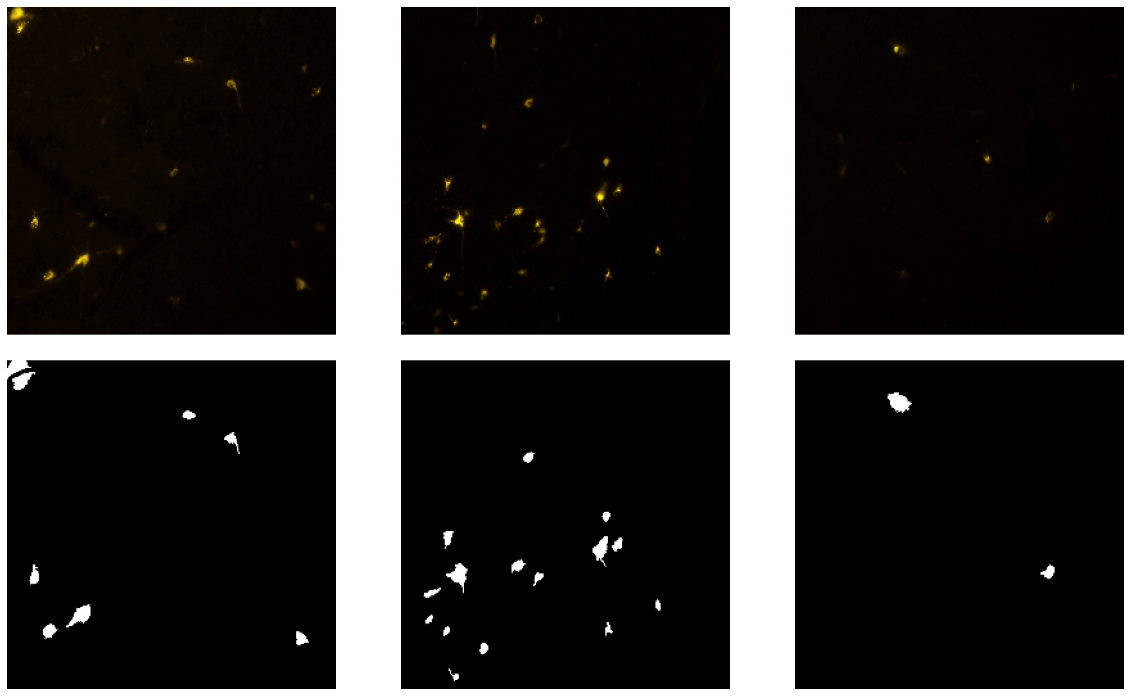

In [24]:
plt.figure(figsize=(20, 20))
r_idx = np.random.randint(0, src.shape[0], 3)
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.vstack([src[r_idx[i]], np.full((20, img_shape[1], img_shape[2]), 255), tar[r_idx[i]]]))
    plt.axis('off')
plt.show()

# Pix2Pix Model :

In [26]:
class Pix2Pix():
    def __init__(self, discrminator_path=None, generator_path=None):
        # useful constants
        self.data_shape = img_shape
        
        # if given as input the model will be loaded from the given path
        # this helps us to keep training the model from the last checkpoint
        if discrminator_path:
            self.discriminator = load_model(discrminator_path)
        else:    
            self.discriminator = self.build_discriminator()

        # compiling the discriminator with a binary crossentropy loss as mentionned in the report
        # with the same optimizer and the same metrics
        self.discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5),
                                  loss_weights=[0.5])
        
        # same as the discriminator
        if generator_path:
            self.generator = load_model(generator_path)
        else:
            self.generator = self.build_generator()

        # at the begining the discriminator is not trained, so we use the generator as a fixed model
        self.discriminator.trainable = False

        # combined means generator, we set it to combined because the backprogragation 
        # has to be done not only on the generator (U-net) but also on the discriminator
        # so by combining them we we backward the disc loss to the generator
        combined_input = Input(shape=self.data_shape)
        gen_output = self.generator(combined_input)
        dis_output = self.discriminator([combined_input, gen_output])
        self.combined = Model(combined_input, [dis_output, gen_output])
        
        # compiling the combined model with a binary crossentropy loss as mentionned in the report
        # (which is the one for the discriminator of course, it's mentionned twice because the discriminator
        # training alone is not same as the combined model training)
        # MAE loss for the generator, i mention that it is also possible to use a MSE which sometimes can be better
        # depending on the treated problem. MAE gives us smoother results, i guess it's better for segmentation
        # but this is clearly not that much important since the data are mostly sparse binary images.
        self.combined.compile(loss=['binary_crossentropy', 'mae'], optimizer=Adam(0.0002, 0.5),
                            loss_weights=[1, 100])
        
    
    def build_discriminator(self):
        # Using a normal distribution to initialize the weights (always more stable)
        init = RandomNormal(stddev=0.02)

        # defining inputs
        src_disc_input = Input(shape=self.data_shape)
        target_disc_input = Input(shape=self.data_shape)
        
        # merging inputs (Fake image input and real image input)
        merged = Concatenate()([src_disc_input, target_disc_input])
        
        # Never use a batch normalization at the first layer, it's not working properly
        X = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merged)
        X = LeakyReLU(alpha=0.2)(X)
        
        # default conv layer: Conv2D followed by a batchNorm followed by a LeakyRelu activation
        X = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(X)
        X = BatchNormalization()(X)
        X = LeakyReLU(alpha=0.2)(X)
    
        X = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(X)
        X = BatchNormalization()(X)
        X = LeakyReLU(alpha=0.2)(X)

        X = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(X)
        X = BatchNormalization()(X)
        X = LeakyReLU(alpha=0.2)(X)

        X = Conv2D(512, (4, 4), padding='same', kernel_initializer=init)(X)
        X = BatchNormalization()(X)
        X = LeakyReLU(alpha=0.2)(X)
        
        # same at the ending, never use a batch normalization at the last layer
        X = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(X)
        X = Activation('sigmoid')(X)
        
        discriminator = Model([src_disc_input, target_disc_input], X, name='discriminator')
        return discriminator
    
    # Function used for building the generator (U net)
    # We set the batchNorm as a parameter because it's important to not set it on input layer
    # and also never use it with Dropout because it mistakes the normalization (since dropout disables
    # neurons randomly, the batchNorm will count all the neurons on it's formulas, which is not what we want)
    def downsample_block(self, link, filters, norm=True):
        # Downsampling consists of a normal convolution and a batch normalization then a LeakyRelu
        X = Conv2D(filters, (4, 4), (2, 2), padding='same', kernel_initializer=RandomNormal(stddev=0.02),
                  use_bias=(not norm))(link)
        if norm:
            X = BatchNormalization()(X)
        X = LeakyReLU(0.2)(X)
        return X
    
    # Upsampling block is the same as the downsampling block but with a transposed convolution
    # same problem for the batch normalization and dropout conflicts
    # an better parameter here was to set kernel to 5x5 instead of 4x4 in order to avoid fragments on outputs
    # (mentionned on the report)
    def upsample_block(self, link, skip, filters, drop=True, norm=False):
        X = Conv2DTranspose(filters, (4, 4), (2, 2), padding='same', kernel_initializer=RandomNormal(0.02),
                           use_bias=False)(link)
        if norm:
            X = BatchNormalization(momentum=0.9)(X)
        if drop:
            X = Dropout(0.5)(X)
        X = Concatenate()([X, skip])
        X = LeakyReLU(0.2)(X)
        return X
    

    # Building the generator
    def build_generator(self):
        encoder_input = Input(shape=self.data_shape)
        
        # Encoder part, No batch normalization on the first layer
        X1 = self.downsample_block(encoder_input, 64, norm=False)
        X2 = self.downsample_block(X1, 128)
        X3 = self.downsample_block(X2, 256)
        X4 = self.downsample_block(X3, 512)
        X5 = self.downsample_block(X4, 512)
        X6 = self.downsample_block(X5, 512)
        X7 = self.downsample_block(X6, 512)
        
        # Middle connection
        X = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=RandomNormal(0.02))(X7)
        X = Activation('relu')(X)
        
        # Decoder part
        # No norm at the first layer, better use dropout on first layers and then normlizing on the after ones
        # For the last layer, no dropout and no norm as explained above
        X = self.upsample_block(X, X7, 512, drop=True, norm=False)
        X = self.upsample_block(X, X6, 512, drop=True, norm=False)
        X = self.upsample_block(X, X5, 512, drop=True, norm=False)
        X = self.upsample_block(X, X4, 512, drop=False, norm=True)
        X = self.upsample_block(X, X3, 256, drop=False, norm=True)
        X = self.upsample_block(X, X2, 128, drop=False, norm=True)
        X = self.upsample_block(X, X1, 64, drop=False, norm=False)
        
        X = Conv2DTranspose(3, (4, 4), (2, 2), padding='same', kernel_initializer=RandomNormal(0.02))(X)
        X = Activation('tanh')(X)
        
        generator = Model(encoder_input, X, name='generator')
        return generator
    
    # Training function
    # parameters:
    #   - epochs: number of epochs
    #   - batch_size: size of the batch
    #   - step: number of iterations for each epoch (set it to size of dataset for a true epoch value)
    #   - save_at: number of epochs between each save
    def train(self, epochs=50, step=100, batch_size=1, save_at=2):
        # initialize some useful constants, like the output shape of the discriminator
        d_output = self.discriminator.output_shape[1]
        progbar = Progbar(step)

        # we initiate some empty arrays for storing the losses
        total_d_loss_real = []
        total_d_loss_fake = []
        total_g_loss = []
        stats = []
        
        # for each epoch
        for epoch in range(1, epochs + 1):
            for i in range(step):
                progbar.update(i + 1)
                
                # we take a sample of real data randomly (image, gt_mask)
                real_s, real_t = sample_date(batch_size, src, tar)
                # we generate outputs for the discriminator, outputs here are ones since those are real data
                # it could be possible to add some normal noise to these outputs to make the training more stable
                # for example, 0.97 instead of 1.0 ... etc
                real_labels = np.ones((batch_size, d_output, d_output, 1))
                
                # we get fake data now, we generate it with the generator
                # and assign zeros 
                fake_s = self.generator.predict(real_s)
                fake_labels = np.zeros((batch_size, d_output, d_output, 1))
                
                # we train the discriminator with the real data and the fake data
                # DO NEVER train on mixed batches, always train on real first and then fake (or inversed)
                d_loss_real = self.discriminator.train_on_batch([real_s, real_t], real_labels)
                d_loss_fake = self.discriminator.train_on_batch([real_s, fake_s], fake_labels)

                # we train the generator then (combined model) by giving it real input images and masks
                # real_t doesn't matter here, we just want to train the generator
                # note that backpropagation is done on the combined model, so it runs on the discriminator too
                # and this is what makes the generator learn better the signal of data
                g_loss, _, _ = self.combined.train_on_batch(real_s, [real_labels, real_t])
                
                # appending the losses
                total_d_loss_fake.append(d_loss_fake)
                total_d_loss_real.append(d_loss_real)
                total_g_loss.append(g_loss)
                
                stats.append((d_loss_fake, d_loss_real, g_loss))
                
            # print the losses for the current epoch
            print('Epoch %d : Real discriminator loss : %f --- Fake discriminator loss : %f --- Generator loss : %f'
                 % (epoch, np.mean(total_d_loss_real), np.mean(total_d_loss_fake), np.mean(total_g_loss)))
            test_sample = denorm_img(self.generator.predict(real_s))

            # show the test sample
            show_sample(test_sample, 1, 1)
            total_d_loss_fake.clear()
            total_d_loss_real.clear()
            total_g_loss.clear()
            
            # saving the model every save_at epochs
            if epoch % 10 == 0:
                self.discriminator.save('discriminator_model')
                self.generator.save('generator_model')
                print('models saved')
                with open('stats {}.pickle'.format(epoch), 'wb') as f:
                    pickle.dump(stats, f)
                print('stats saved')
    
    # function to display actual architecture of the model
    def summary(self):
        self.discriminator.summary()
        self.generator.summary()
        self.combined.summary()
        

# Training :

In [29]:
# instanciating the model (with pretrained weights here, but first no need to load anything at first time)
p2p = Pix2Pix(discrminator_path='discriminator_model/', generator_path='generator_model/')
p2p.summary()
print('models loaded from pretrained weights!')

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_32 (Concatenate)    (None, 256, 256, 6)  0           input_17[0][0]                   
                                                                 input_18[0][0]                   
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 128, 128, 64) 6208        concatenate_32[0][0] 

100/100 [==============================] - 6261s 63s/step
Epoch 150 : Real discriminator loss : 1.122627 --- Fake discriminator loss : 1.745051 --- Generator loss : 0.291756


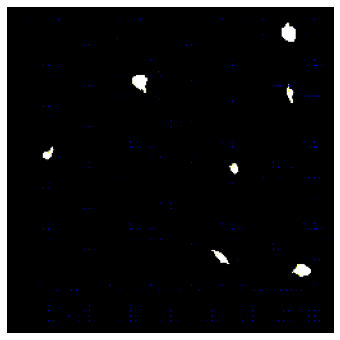

INFO:tensorflow:Assets written to: discriminator_model\assets
INFO:tensorflow:Assets written to: generator_model\assets
models saved
stats saved
100/100 [==============================] - 6315s 63s/step
Epoch 151 : Real discriminator loss : 1.119012 --- Fake discriminator loss : 1.530504 --- Generator loss : 0.291931


In [86]:
# lauching the training, here we set batch size to 4, but you can increase it to whatever you want
# as long as you have enough gpu memory
# the 1000 epochs here are symbolic, in reality we just train for an unfixed amount of time and check the results
# on this case we decided to stop the training after around 5 hours
p2p.train(src, tar, batch_size=4, epochs=1000)

# I kept to give you and idea of th training process

## Saving model :

In [90]:
# saving our models (even though we don't need the discriminator for the use but just to retrain again)
p2p.discriminator.save('discriminator_model')
p2p.generator.save('generator_model')

print('models saved')

INFO:tensorflow:Assets written to: discriminator_model\assets
INFO:tensorflow:Assets written to: generator_model\assets
models saved


### Clearing GPU memory :

In [22]:
# Small code used  to clear gpu memory
from numba import cuda
cuda.select_device(0)
cuda.close()

### Displaying results :

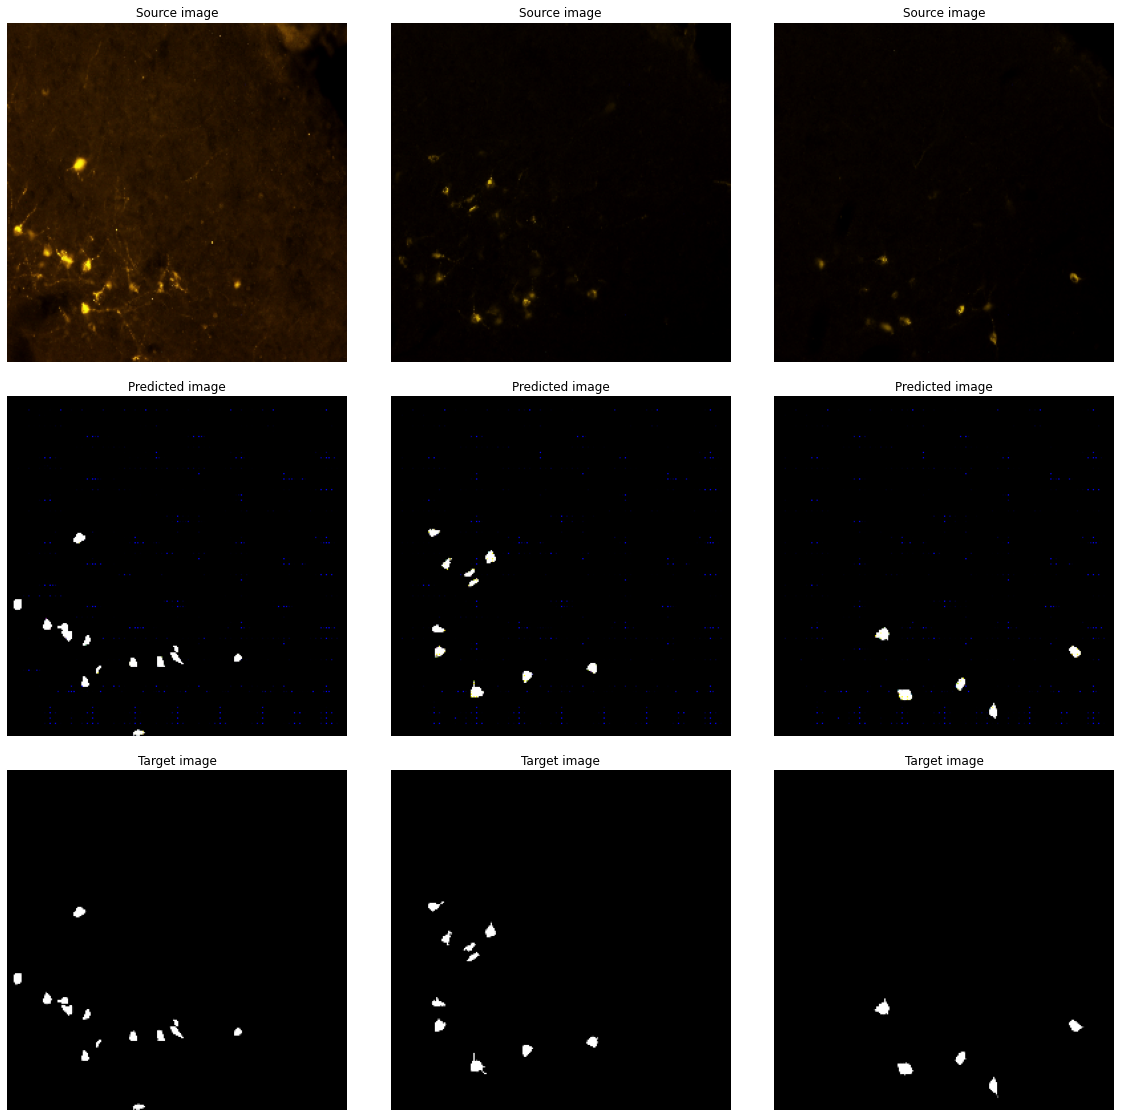

In [54]:
# Choix de 3 images aléatoires dans notre dataset
sample_size = 3
src_test, tar_test = sample_date(sample_size, src, tar)

# dénormalisation des images étant donné que la fonction "sample_data" fait une normalisation
tar_test = denorm_img(tar_test)

# prédiction des masques
predicted = denorm_img(p2p.generator.predict(src_test))
src_test = denorm_img(src_test)

plt.figure(figsize=(20, 20))
for i in range(sample_size):
    plt.subplot(sample_size, 3, i + 1)
    plt.imshow(src_test[i])
    plt.axis('off')
    plt.title('Source image')
    plt.subplot(sample_size, 3, i + 1 + sample_size)
    plt.imshow(predicted[i])
    plt.axis('off')
    plt.title('Predicted image')
    plt.subplot(sample_size, 3, i + 1 + 2 * sample_size)
    plt.imshow(tar_test[i])
    plt.axis('off')
    plt.title('Target image')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()
    